# comparing loss functions
## a graphical analysis
> Sammer, Matthias & Leitner, Paul

### Definition, explanation
*A loss function is used to optimize the parameter values in a neural network model. 
Loss functions map a set of parameter values for the network onto a scalar value 
that indicates how well those parameter accomplish the task the network is intended to do.* 

Here we will graphically examine a few of the most common loss functions in more detail, 
in order to gain a more intuitive understanding of the underlying principles in Python

### Preparation, packages, data generation

since data wrangling is not the exact scope of this investigation, we quickly generate some data from sklearn

In [1]:
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# generate a large amount of data, unscaled - 20% noise in order to challenge the model
X, y = make_regression(n_samples=1000,
                       n_features=20,
                       noise=.1,
                       random_state=1)

# this data is of course unscaled --> preprocess the data
# usually this would include imputation, EDA, encoding - out of scope here
pipe_x = Pipeline(steps=[('scaling', StandardScaler())])
pipe_y = Pipeline(steps=[('scaling', StandardScaler())])

X_processed = pipe_x.fit_transform(X)
y_processed = pipe_y.fit_transform(y.reshape(-1, 1))

train_X, test_X, train_y, test_y = train_test_split(X_processed, y_processed, 
                                                    random_state=1,
                                                    test_size=.1)

### model generation

we quickly generate a sequential NN - as a simple demonstration for graphing the loss

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializers import he_uniform


# simple sequential model, dense layer, relu activation
sequential_model = Sequential()

bias_initializer = he_uniform(seed=42)
sequential_model.add(Dense(25, 
                           input_dim=20, 
                           activation='relu',
                           kernel_initializer=bias_initializer))
sequential_model.add(Dense(1, 
                           activation='linear'))

# using a simple gradient descent optimizer
opt = SGD(lr=0.01, 
          momentum=0.9)

sequential_model.compile(loss='mean_squared_error', 
                         optimizer=opt)

Using TensorFlow backend.


> now that we initialized the model, we train it with history and graph the (MSE) loss

Train MSE: 0.0003, Test MSE: 0.0003 



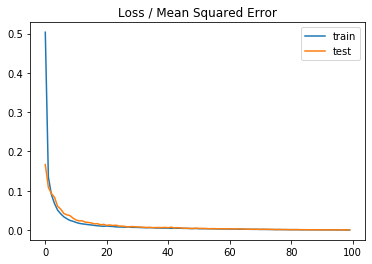

In [3]:
import matplotlib.pyplot as plt


# train the model on our test data in 100 epochs
loss_history = sequential_model.fit(train_X, train_y, 
                                    validation_data=(test_X, test_y), 
                                    epochs=100, 
                                    verbose=0)

# get the final train and test MSE of the model
train_mse = sequential_model.evaluate(train_X, train_y, 
                                      verbose=0)

test_mse = sequential_model.evaluate(test_X, test_y, 
                                     verbose=0)

print(f'Train MSE: {round(train_mse, 4)}, Test MSE: {round(test_mse, 4)} \n')

# plot loss over the training epochs
plt.title('Loss / Mean Squared Error')
plt.plot(loss_history.history['loss'], label='train')
plt.plot(loss_history.history['val_loss'], label='test')
plt.legend()
plt.show()


sequential network cross entropy loss - Train MSE: 0.029335936109224955, Test MSE: 0.0265955913066864


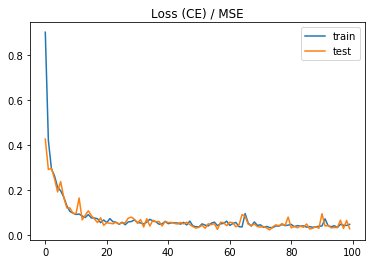

In [8]:
mae = Sequential()
mae.add(Dense(25,
                           input_dim=20,
                           activation='relu',
                           kernel_initializer=bias_initializer))
mae.add(Dense(1,
                           activation='linear'))
mae.compile(loss='mean_absolute_error',
            optimizer=opt)

mae_loss_history = mae.fit(train_X, train_y,
                           validation_data=(test_X, test_y),
                           epochs=100,
                           verbose=0)
mae_train_mse = mae.evaluate(train_X, train_y,
                             verbose=0)
mae_test_mse = mae.evaluate(test_X, test_y, 
                            verbose=0)

print(f'sequential network cross entropy loss - Train MSE: {mae_train_mse}, Test MSE: {mae_test_mse}')

# plot loss over training 
plt.title('Loss (CE) / MSE')
plt.plot(mae_loss_history.history['loss'], label='train')
plt.plot(mae_loss_history.history['val_loss'], label='test')
plt.legend()
plt.show()